<a href="https://colab.research.google.com/github/silveiraluisf/ODIN/blob/main/LUIS_ODIN_working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

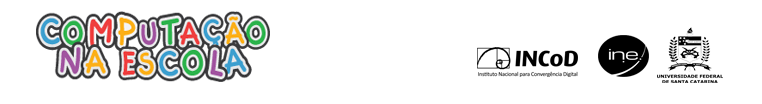

Visual User Interface for Jupyter
Desenvolva o seu modelo de machine learning para a detecção de objetos neste ambiente visual de Jupyter Notebook.

O ambiente visual suporta um processo básico de desenvolvimento de um modelo de ML voltado ao ensino de ML no Ensino Médio.

A interface visual foi criada pela Iniciativa Computação na Escola/INCoD/INE/UFSC.


# Como usar este notebook

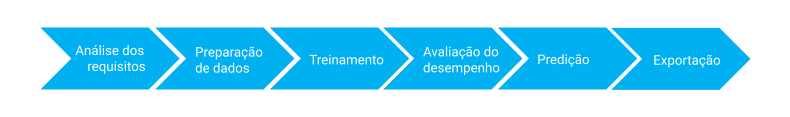

Seguindo esse processo você deve ter coletado os dados no seu google drive e ter feito as anotações das imagens, separando entre pastas de train, valid e test. Ou então, feito as anotações das imagens e gerado o "code snippet" dentro do Roboblow.

Para iniciar a interface visual você precisa primeiro rodar a próxima célula para carregar no notebook a interface visual. Uma vez carregado, não será necessário executá-la novamente durante o uso. É normal demorar pois todos os frameworks são importados nesta etapa.

Em seguida, a última célula deve ser executada para dar início a interface visual, assim sendo possível começar o processo de ML. Atualmente em caso de erro ou caso deseje começar de novo você deverá executar essa célula novamente.

In [15]:
#@title Execute esta célula para preparar a interface visual

# Importacao via python da biblioteca fastai
![ -e /content ] | tee -a >> log.txt && pip install ipywidgets | tee -a >> log.txt && jupyter nbextension enable --py widgetsnbextension | tee -a >> log.txt

# Biblioteca Fastai para facilitar o trabalho com aprendizado de máquina
import os  # Módulo para interagir com o sistema operacional
from pathlib import Path  # Para manipulação de caminhos
import glob  # Para encontrar arquivos usando padrões
import re  # Para expressões regulares

#Path.ls
from fastai.data import core

# Importação da biblioteca Ultraytics para trabalhar com o modelo YOLO
!pip install ultralytics==8.0.196  # # Versão ultralytics necessária para conseguir fazer exportação do modelo treinado para o roboflow
import ultralytics  # Importação da biblioteca Ultraytics
ultralytics.checks()  # Verificações de instalação do Ultraytics
from ultralytics import YOLO  # Importação da classe YOLO

# Importação da biblioteca Roboflow para integração com a plataforma Roboflow
!pip install roboflow  # Instalação da biblioteca Roboflow
from roboflow import Roboflow  # Importação da classe Roboflow

# Importação de bibliotecas para manipulação de dados e gráficos
import numpy as np  # Biblioteca para cálculos numéricos
import matplotlib.pyplot as plt  # Biblioteca para visualização de dados
import cv2  # Biblioteca para processamento de imagens

# Biblioteca PyTorch para treinamento de modelos
import torch  # Importação do PyTorch
print("GPU Available: ", torch.cuda.is_available())  # Verifica se a GPU está disponível

# Importação para manipulação de arquivos YAML
import yaml  # Para trabalhar com arquivos de configuração em formato YAML

# Importação para exibição de imagens no Jupyter Notebook
from IPython.display import Image, display, clear_output  # Para exibir imagens e limpar a saída

# Importações específicas do Google Colab
from google.colab import drive  # Para montar o Google Drive
from google.colab import widgets as colabwidgets  # Para usar widgets no Google Colab

# Importação de widgets do IPython
import ipywidgets as widgets  # Biblioteca para criar interfaces interativas
from ipywidgets import widgets as ipywidgets
from IPython.display import display  # Para exibir widgets

# Importação para manipulação de processos e controle de tempo
import subprocess  # Para executar comandos do sistema
import time  # Para funções de temporização
import threading  # Para executar tarefas em paralelo
import shutil  # Para operações de arquivo de alto nível

# Suprimir saída de comando
from IPython.utils import io  # Para controle de saída

# Renderização e exportação
import re  # Para expressões regulares

class m_Header():
  def __init__(self, header, step):
    href = 'https://github.com/silveiraluisf/ODIN/blob/main/' + step + '.md'
    html = '<p style=font-family:Arial><b>' + header + '<b/> <a target="_blank" href={}> ?</a> <p>'.format(href)
    self.header = ipywidgets.HTML(html)

class m_Ret():
  def __init__(self, txt, flag):
    if flag == 1:
      self.txt = ipywidgets.HTML(value='<p style="text-align: left;style=font-family:Arial"><span style="color: #339966;">' + txt + '</span></p>')
    if flag == 2:
      self.txt = ipywidgets.HTML(value='<p style="text-align: left;style=font-family:Arial"><span style="color: #ff0000;">' + txt + '</span></p>')

# Função para a conexão com o GDrive
def drive_connect():
  drive.mount('/content/gdrive', force_remount=True)
  drive_connect.root_dir = "/content/gdrive/MyDrive"
  return True

# Função para upload de imagens do Roboflow
def parse_roboflow_snippet(snippet:str) -> str:
  snippet = snippet.replace("!pip install roboflow\n\nfrom roboflow import Roboflow\n","global dataset\n")
  return snippet

# Função para puxar a versão do YOLO selecionada
def get_yolo_version():
    return os.environ.get("YOLO_VERSION", "YOLOv8")  # Valor padrão é YOLOv8

# Atributos do Dataset
os.environ["DATASET_DIRECTORY"] = ""
os.environ["CONFIG_YAML"] = ""
os.environ["YOLO_VERSION"] = "YOLOv8"  # Define a versão YOLO como variável de ambiente
dataset_total_images = 0
dataset_dict_labels = {}

# Configura a api key como uma variável de ambiente
os.environ["ROBOFLOW_API_KEY"] = "YOUR_API_KEY"

# Layouts e Styles
l_txt = ipywidgets.Layout(width='66%')
l_btn = ipywidgets.Layout(width='40%')
l_vbox = ipywidgets.Layout(width='720px')
l_hbox = ipywidgets.Layout(width='90%')
l_req = ipywidgets.Layout(width='95%', height='90px')
l_codesnippet = ipywidgets.Layout(width='66%', height='120px')
l_hidden_red = ipywidgets.Layout(width='90%', visibility = 'hidden')
l_hidden_tra = ipywidgets.Layout(width='90%', visibility = 'hidden')
l_btn_hbox = ipywidgets.Layout(flex_flow='column',align_items='center')
s_desc_wid = {'description_width':'25%'}

# Lista de selecao dos modelos YOLOv8
yolov8_models = ['yolov8n', 'yolov8s', 'yolov8m', 'yolov8l', 'yolov8x']

# Lista de selecao da versao do yolo
model_versions = ['YOLOv8']

# Lista de tipos para exportar
export_list = ['pt', 'onnx', 'tflite', 'torchscript', 'pb']

def total_by_category():
    folders = Path(os.environ["DATASET_DIRECTORY"]).ls()
    total_images = 0
    dict_category = {}

    # Abre e analisa o arquivo YAML usando a biblioteca yaml
    with open(os.environ["CONFIG_YAML"], 'r') as file_data_yaml:
        data = yaml.safe_load(file_data_yaml)

    if 'names' in data:
        classes = data['names']
    else:
        raise ValueError("Nenhuma definição de classe encontrada no arquivo data.yaml.")

    for _class in classes:
        dict_category[_class] = 0

    for folder in folders:
        if os.path.isfile(folder):
            continue
        if Path(folder/"labels").is_dir() and Path(folder/"images").is_dir():
            for file_path in Path(folder/"labels").iterdir():
                with open(file_path) as file_label:
                    for line in file_label.readlines():
                        number_class = line.split(" ")[0]
                        dict_category[classes[int(number_class)]] += 1

    return total_images, dict_category

def generate_images_preview():
    images_preview = []
    folders = Path(os.environ["DATASET_DIRECTORY"]).ls()
    dict_classes_color = {}

    # Abre e analisa o arquivo YAML usando yaml.safe_load
    with open(os.environ["CONFIG_YAML"], 'r') as file_data_yaml:
        data = yaml.safe_load(file_data_yaml)

    if 'names' in data:
        classes = data['names']
    else:
        raise ValueError("Nenhuma definição de classe encontrada no arquivo data.yaml.")

    # Define caminhos para rotulos e imagens de treinamento
    labels_path = os.path.join(os.environ["DATASET_DIRECTORY"], "train/labels")
    trains_path = os.path.join(os.environ["DATASET_DIRECTORY"], "train/images")

    # Obtem a lista de rotulos e imagens de treinamento
    labels = Path(labels_path).ls()
    trains = Path(trains_path).ls()

    # Cria dicionários para rótulos e imagens correspondentes
    labels_dict = {}
    trains_dict = {}

    # Mapeia rótulos para seus nomes de arquivo
    for label in labels:
        str_label = str(label)
        label_file = str_label.split("/")[-1]
        label_file_name = "".join(label_file.split(".txt")[:-1])
        labels_dict[label_file_name] = label

    # Atribui cores aleatórias a cada classe
    for _class in classes:
        dict_classes_color[_class] = list(np.random.choice(range(255), size=3))

    # Gera visualizações de imagens com caixas delimitadoras
    for i in range(6):
        if len(trains) < i:
            break
        str_train = str(trains[i])
        train_file = str_train.split("/")[-1]
        train_file_name = "".join(train_file.split(".jpg")[:-1])

        # Encontra o rótulo correspondente para a imagem
        label = labels_dict.get(train_file_name, None)
        if label is None:
            continue

        with open(label) as file_label:
            img = cv2.imread(str_train)
            for line in file_label.readlines():
                line_split = line.split(" ")
                number_class = int(line_split[0])
                coordenates = line_split[1:]

                # Obtem as dimensões da imagem e calcula as coordenadas da caixa delimitadora
                h, w, _ = img.shape
                x = h * float(coordenates[0])
                y = w * float(coordenates[1])
                label_h = (h * float(coordenates[2])) / 2
                label_w = (w * float(coordenates[3])) / 2
                x1 = int(x - label_w)
                y1 = int(y + label_h)
                x2 = int(x + label_w)
                y2 = int(y - label_h)

                # Desenha a caixa delimitadora e o rótulo
                _class = classes[number_class]
                r, g, b = dict_classes_color[_class]
                cv2.rectangle(img, (x1, y1), (x2, y2), (int(r), int(g), int(b)), 3)
                cv2.putText(img, text=_class, org=(x1, y1-10),
                            fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1,
                            color=(0, 0, 0), thickness=2, lineType=cv2.LINE_AA)

        # Salva o preview da imagem
        image_preview = "img_preview" + str(i) + ".jpg"
        cv2.imwrite(image_preview, img)
        images_preview.append(image_preview)

    return images_preview, dict_classes_color, classes

def render_categories(total_images, category_dict):
        chart_labels = []
        chart_quantities = []
        for i in category_dict:
            chart_labels.append(i)
            chart_quantities.append(category_dict[i])

        x = np.arange(len(chart_labels))

        width = 0.5

        fig, ax = plt.subplots()

        bar_colors = ['#2196F3'] * len(chart_labels)

        rects = ax.bar(x, chart_quantities, width, color=bar_colors)
        fig.set_figheight(6)
        fig.set_figwidth(10)

        ax.set_ylabel('Objetos')
        ax.set_title('Objetos por categoria')
        ax.set_xticks(x)
        ax.set_xticklabels(chart_labels)
        ax.set_frame_on(False)

        plt.show()

# Função que renderiza a janela de Analise De Requisitos
def render_analise_de_requisitos(tab):
  with tab.output_to(0, select=True):
    grid0 = colabwidgets.Grid(1, 1)
    with grid0.output_to(0,0):

      lbl_cat = ipywidgets.Label(value = "Categorias:")
      txta_cat1 = ipywidgets.Textarea(value='',placeholder='Descrição das categorias de objetos que devem ser detectados \nex. 10 categorias de objetos encontrados dentro de casa, que podem interferir no dia a dia de uma pessoa com deficiência visual: Armário, Cachorro, Cadeira, Cama, Criado Mudo, Mesa, Mochila, Porta, Sapato e Sofá',disabled=False,layout=l_req)

      lbl_fontededados = ipywidgets.Label(value = "Fonte de dados:")
      txta_fontededados = ipywidgets.Textarea(value='',placeholder='ex. imagens coletadas pelos criadores do modelo',disabled=False,layout=l_req)

      lbl_qtddedados = ipywidgets.Label(value = "Quantidade de dados:")
      txta_qtddedados = ipywidgets.Textarea(value='',placeholder='ex. No mínimo 30 exemplares para cada categoria',disabled=False,layout=l_req)

      lbl_pdr_img = ipywidgets.Label(value = "Padronização das imagens:")
      txta_pdr_img1 = ipywidgets.Textarea(value='',placeholder='Descrição do formato das imagens \nex. Formato: .jpg, Tamanho: 640x640 pixels',disabled=False,layout=l_req)

      lbl_rotulacao = ipywidgets.Label(value = "Rotulação dos dados:")
      txta_rotulacao = ipywidgets.Textarea(value='',placeholder='Descreve por quem e como foram as anotações das imagens \nex. Por estudantes de curso de computação no ensino superior e rotulados na ferramenta roboflow',disabled=False,layout=l_req)

      lbl_desempenho = ipywidgets.Label(value = "Desempenho esperado:")
      txta_desempenho = ipywidgets.Textarea(value='',placeholder='Especifique o desempenho esperado (usando uma ou mais medidas (mAP 0.5, mAP 0.95, precision, recall, F1 score) \nex. mAP0.5 ou 0.95: no mínimo 75%, Precision: no minimo 75%, Recall: no minimo 75%...',disabled=False,layout=l_req)

      itens_req = ipywidgets.VBox([ ipywidgets.VBox([lbl_cat, txta_cat1], layout=l_hbox),
                                    ipywidgets.VBox([lbl_fontededados, txta_fontededados], layout=l_hbox),
                                    ipywidgets.VBox([lbl_qtddedados, txta_qtddedados], layout=l_hbox),
                                    ipywidgets.VBox([lbl_pdr_img, txta_pdr_img1], layout=l_hbox),
                                    ipywidgets.VBox([lbl_rotulacao, txta_rotulacao], layout=l_hbox),
                                    ipywidgets.VBox([lbl_desempenho, txta_desempenho], layout=l_hbox)],layout=l_vbox)

      display(itens_req)

# Função que renderiza a janela para preparação dos dados
def render_preparacao_dos_dados(tab):
    with tab.output_to(1, select=False):
        grid1 = colabwidgets.Grid(6,1)

        # Cria as abas para diretório do arquivo e Roboflow Snippet
        sub_tabs = ipywidgets.Tab()
        file_directory_tab = ipywidgets.VBox()
        roboflow_snippet_tab = ipywidgets.VBox()

        # Renderização da aba de importação dos dados via Google Drive
        with grid1.output_to(1,0):
            lbl_path = m_Header('Caminho do seu conjunto de dados', 'PREPARACAO_DOS_DADOS')
            input_path = ipywidgets.Text(placeholder='Insira o caminho do seu conjunto de dados ex: mask-dataset', value='', layout=l_txt)
            btn_path = ipywidgets.Button(description='Carregar caminho', layout=l_btn, button_style='primary', disabled=True)
            hbox_path = ipywidgets.HBox([input_path, btn_path], layout=l_hbox)
            vbox_path = ipywidgets.VBox([lbl_path.header, hbox_path], layout=l_vbox)
            file_directory_tab.children = [vbox_path]

            # Confere o input e habilita o botão
            def check_input_path(_):
                btn_path.disabled = not input_path.value.strip()

            input_path.observe(check_input_path, names='value')

            def on_btn_path_clicked(a):
                with grid1.output_to(1,0):
                    grid1.clear_cell()

                    user_input = input_path.value.strip()
                    dataset_directory = os.path.join(drive_connect.root_dir, user_input)

                    print(f"Conferindo diretório: {dataset_directory}")

                    # Define a variável de ambiente para o caminho do diretório
                    os.environ["DATASET_DIRECTORY"] = dataset_directory

                    if Path(dataset_directory).is_dir():
                        create_config_files()
                        msg_ret = m_Ret(f'Path: {dataset_directory} definido com sucesso', 1)
                    else:
                        msg_ret = m_Ret(f'Path: {dataset_directory} não encontrado', 2)

                    display(msg_ret.txt)

            btn_path.on_click(on_btn_path_clicked)

        # Renderização da tab de importação dos dados via Roboflow
        with grid1.output_to(0,0):
            lbl_path = m_Header('Code snippet', 'PREPARACAO_DOS_DADOS')
            input_snippet = ipywidgets.Textarea(placeholder='Insira o code snippet exportado do Roboflow. \nAtenção! o formato deve ser YOLOv8.', value='', layout=l_codesnippet)
            btn_snippet = ipywidgets.Button(description='Carregar imagens', layout=l_btn, button_style='primary', disabled=True)
            hbox_snippet = ipywidgets.HBox([input_snippet, btn_snippet], layout=l_hbox)
            vbox_snippet = ipywidgets.VBox([lbl_path.header, hbox_snippet], layout=l_vbox)
            roboflow_snippet_tab.children = [vbox_snippet]

            # Confere o input e habilita o botão
            def check_input_snippet(_):
                btn_snippet.disabled = not input_snippet.value.strip()

            input_snippet.observe(check_input_snippet, names='value')

            def on_btn_snippet_clicked(a):
              with grid1.output_to(1, 0):
                  grid1.clear_cell()
                  with io.capture_output() as captured:
                      rf = Roboflow()
                      global dataset
                      try:
                          # Executa o snippet para inicializar o conjunto de dados
                          exec(parse_roboflow_snippet(input_snippet.value))
                      except Exception as e:
                          msg_ret = m_Ret(f"Erro ao carregar o conjunto de dados: {str(e)}", 2)
                          display(msg_ret.txt)
                          return

                  # Define o local do conjunto de dados no objeto do conjunto de dados
                  dataset_location = dataset.location
                  os.environ["DATASET_DIRECTORY"] = dataset_location

                  # Detecta e define automaticamente o caminho para o arquivo data.yaml
                  data_yaml_path = os.path.join(dataset_location, 'data.yaml')
                  if Path(data_yaml_path).is_file():
                      os.environ["CONFIG_YAML"] = data_yaml_path
                      msg_ret = m_Ret('Conjunto de dados e arquivo data.yaml carregado com sucesso', 1)

                  else:
                      msg_ret = m_Ret('Erro: Arquivo data.yaml não encontrado no conjunto de dados', 2)

                  display(msg_ret.txt)

            btn_snippet.on_click(on_btn_snippet_clicked)

        sub_tabs.children = [file_directory_tab, roboflow_snippet_tab]
        sub_tabs.set_title(0, 'Caminho do Conjunto de Dados')
        sub_tabs.set_title(1, 'Snippet do Roboflow')

        with grid1.output_to(0, 0):
            display(sub_tabs)

        render_dataset_info_and_preview(grid1)

# Função para lidar com informações do conjunto de dados e visualização de imagens
def render_dataset_info_and_preview(grid1):
    with grid1.output_to(2, 0):
        lbl_dataset_info = ipywidgets.Label(value="Visualizar informações do conjunto de dados")

        btn_view_total_by_category = ipywidgets.Button(description='Ver quantidade de objetos por categoria', layout=l_btn, button_style='primary')
        hbox_dataset_info = [lbl_dataset_info, ipywidgets.Box([btn_view_total_by_category], layout=l_btn_hbox)]
        vbox_dataset_info = ipywidgets.VBox(hbox_dataset_info, layout=l_vbox)
        display(vbox_dataset_info)

        def on_btn_view_total_by_category(_):
            with grid1.output_to(3, 0):
                grid1.clear_cell()
                try:
                    dataset_total_images, dataset_dict_labels = total_by_category()

                    # Verifica se o conjunto de dados foi carregado
                    if dataset_total_images is None or not dataset_dict_labels:
                        error_label = ipywidgets.Label(value="Erro: Nenhum conjunto de dados carregado.", style={'color': 'red'})
                        display(error_label)
                    else:
                        render_categories(dataset_total_images, dataset_dict_labels)
                except Exception as e:
                    error_label = ipywidgets.Label(value=f"Erro: {str(e)}", style={'color': 'red'})
                    display(error_label)

        btn_view_total_by_category.on_click(on_btn_view_total_by_category)

    # Seção para visualizar imagens do conjunto de dados
    with grid1.output_to(4, 0):
        lbl_img_preview = ipywidgets.Label(value="Visualizar conjunto de dados")
        btn_img_preview = ipywidgets.Button(description='Ver exemplos do conjunto', layout=l_btn, button_style='primary')
        hbox_img_preview = [lbl_img_preview, ipywidgets.Box([btn_img_preview], layout=l_btn_hbox)]
        vbox_img_preview = ipywidgets.VBox(hbox_img_preview, layout=l_vbox)
        display(vbox_img_preview)

        def on_btn_img_preview(_):
            with grid1.output_to(5, 0):
                grid1.clear_cell()
                try:
                    images_preview, dict_classes_color, classes = generate_images_preview()

                    # Verifica se o conjunto de dados foi carregado
                    if not images_preview:
                        error_label = ipywidgets.Label(value="Erro: Nenhum conjunto de dados carregado.", style={'color': 'red'})
                        display(error_label)
                    else:
                        images_widgets = []

                        for image_preview in images_preview:
                            with open(image_preview, "rb") as results:
                                results_image = results.read()
                                results_image_widget = ipywidgets.Image(
                                    value=results_image,
                                    format='png',
                                    width=240,
                                    height=240,
                                )
                                images_widgets.append(results_image_widget)

                        grid = ipywidgets.GridBox(images_widgets, layout=ipywidgets.Layout(grid_template_columns="repeat(3, 240px)"))
                        display(grid)
                except Exception as e:
                    error_label = ipywidgets.Label(value=f"Erro: {str(e)}", style={'color': 'red'})
                    display(error_label)

        btn_img_preview.on_click(on_btn_img_preview)

#Render treinamento
def render_treinamento(tab):
    with tab.output_to(2, select=False):
      grid2 = colabwidgets.Grid(2, 1)

      with grid2.output_to(0, 0):
          lbl_trainning = m_Header('Treinamento do modelo', 'TREINAMENTO')

          lbl_yolo_info = ipywidgets.Label(value="     Versão do YOLO: YOLOv8")

          # Menu suspenso para escolher o modelo com base na versão
          model = ipywidgets.Dropdown(
              options=yolov8_models,
              value=yolov8_models[0],
              description='Modelo:',
              disabled=False,
          )

          # Sliders para batches, image size e epochs
          slider_batches = ipywidgets.IntSlider(min=1, max=128, step=1, value=16,
                                                description_tooltip='Número de lotes',
                                                description='Tamanho do batch',
                                                layout=l_hbox, style=s_desc_wid)
          slider_image_size = ipywidgets.IntSlider(min=64, max=1280, step=64, value=640,
                                                  description_tooltip='Tamanho das imagens',
                                                  description='Tamanho das imagens',
                                                  layout=l_hbox, style=s_desc_wid)
          slider_epochs = ipywidgets.IntSlider(min=1, max=500, step=1, value=25,
                                              description_tooltip='Número de épocas',
                                              description='Quantidade de épocas',
                                              layout=l_hbox, style=s_desc_wid)

          # Botoões para iniciar treinamento e deletar modelo
          btn_train_model = ipywidgets.Button(description='Treinar Modelo', layout=l_btn, button_style='primary')
          btn_delete_model = ipywidgets.Button(description='Deletar Modelo', layout=l_btn,  button_style='warning')

          # Status e barra de progresso
          lbl_status = ipywidgets.Label(value="")
          progress_bar = ipywidgets.IntProgress(value=0, min=0, max=slider_epochs.value, description='Progresso:', bar_style='info', visible=False)

          hbox_trainning = [
              lbl_trainning.header, lbl_yolo_info, model, slider_batches, slider_image_size, slider_epochs,
              ipywidgets.Box([btn_train_model, btn_delete_model], layout=l_btn_hbox), lbl_status, progress_bar
          ]
          vbox_trainning = ipywidgets.VBox(hbox_trainning, layout=l_vbox)
          display(vbox_trainning)

          # Função para simular o progresso do treinamento
          def simulate_progress():
              progress_bar.visible = True
              for i in range(1, slider_epochs.value + 1):
                  time.sleep(7)  # Simula tempo de treinamento
                  progress_bar.value = i

          # Função para treinar o modelo
          def train_model():

            # Use a versão YOLO da variável de ambiente
            yolo_version = get_yolo_version()

            if yolo_version == 'YOLOv8':
              # Construct the command string
              command = f"yolo task=detect mode=train model=yolov8/{os.environ['MODEL']}.pt data={os.environ['CONFIG_YAML']} epochs={os.environ['EPOCHS']} imgsz={os.environ['IMAGE_SIZE']} batch={os.environ['BATCHES']} project=runs/train name=exp"

            # Execute the command and capture the output
            process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout, stderr = process.communicate()

            # Decode and split the output
            final_output = stdout.decode('utf-8').split('\n')

            # Flag to start printing after 'Model summary (fused):' is found
            start_printing = False
            skip_first_line = False

            for line in final_output:
                if 'Model summary (fused):' in line:
                    print("\033[1m                Classe  |  Imagens  | Instâncias |  P  |      R      |   mAp50   |   mAP50-95\033[0m")
                    skip_first_line = True
                elif skip_first_line:
                    skip_first_line = False
                    start_printing = True
                elif start_printing:
                    print(line)

          def on_btn_train_model_clicked(b):
              with grid2.output_to(1, 0):
                  btn_train_model.disabled = True
                  btn_delete_model.disabled = True
                  lbl_status.value = "O treinamento do modelo está em andamento, isto pode levar alguns minutos..."

                  os.environ["BATCHES"] = str(slider_batches.value)
                  os.environ["IMAGE_SIZE"] = str(slider_image_size.value)
                  os.environ["EPOCHS"] = str(slider_epochs.value)
                  os.environ["MODEL"] = str(model.value)

                  create_config_files()

                  if Path("./runs/train").is_dir():
                      !rm -rf runs/train

                  # Inicia threads para treinamento e simulação de progresso
                  train_thread = threading.Thread(target=train_model)
                  progress_thread = threading.Thread(target=simulate_progress)

                  train_thread.start()
                  progress_thread.start()

                  train_thread.join()  # Aguarda o treino terminar
                  progress_thread.join()  # Aguarda a conclusão da simulação de progresso

                  progress_bar.value = progress_bar.max
                  progress_bar.bar_style = 'success'
                  lbl_status.value = "Treinamento concluído com sucesso!"
                  btn_train_model.disabled = False
                  btn_delete_model.disabled = False

          btn_train_model.on_click(on_btn_train_model_clicked)

          # Função para excluir os arquivos do modelo treinado
          def on_btn_delete_model_clicked(b):
              with grid2.output_to(1, 0):

                  btn_delete_model.disabled = True

                  # Determina o caminho para o diretório de execuções com base na versão YOLO
                  runs_path = '/content/runs'
                  runs_path_train = '/content/runs/train'

                  runs_path_detect = '/content/runs/detect'

                  # Exclui o diretório se ele existir
                  if Path(runs_path).is_dir():
                      try:
                          shutil.rmtree(runs_path_train)
                          if runs_path_detect:
                              shutil.rmtree(runs_path_detect)
                          lbl_status.value = "Os arquivos do modelo foram deletados com sucesso!"
                      except Exception as e:
                          lbl_status.value = f"Erro ao deletar arquivos do modelo: {str(e)}"
                  else:
                      lbl_status.value = "Diretório do modelo não encontrado."

                  btn_delete_model.disabled = False

          btn_delete_model.on_click(on_btn_delete_model_clicked)


# Render Avaliação
def render_avaliacao(tab):
    with tab.output_to(3, select=False):
        grid6 = colabwidgets.Grid(8, 1)

        # Use a versão YOLO da variável de ambiente
        yolo_version = get_yolo_version()

        # Função para determinar o diretório do experimento com base na versão YOLO
        def get_exp_dir():
            yolo_version = get_yolo_version()
            if yolo_version == 'YOLOv8':
                return "/content/runs/train/exp"

        with grid6.output_to(0, 0):
            lbl_treinamento = ipywidgets.Label(value='Avaliação do treinamento')
            btn_treinamento = ipywidgets.Button(description='Mostrar', layout=l_btn, button_style='primary',style=s_desc_wid)

            box_predict = ipywidgets.VBox([lbl_treinamento, ipywidgets.HBox([btn_treinamento], layout=l_btn_hbox)], layout=l_vbox)
            display(box_predict)

            # Função para avaliar o treinamento
            def on_btn_treinamento(b):
                with grid6.output_to(1, 0):
                    exp_dir = get_exp_dir()
                    results_path = f"{exp_dir}/results.png"
                    if Path(results_path).is_file():
                        with open(results_path, "rb") as results:
                            results_image = results.read()
                            results_image_widget = ipywidgets.Image(
                                value=results_image,
                                format='png',
                                width=720,
                                height=720,
                            )
                            display(results_image_widget)
                    else:
                        display(ipywidgets.Label("Arquivo de resultados não encontrado."))

            btn_treinamento.on_click(on_btn_treinamento)

        with grid6.output_to(2, 0):
            lbl_desempenho = ipywidgets.Label(value='Avaliação do desempenho')
            btn_desempenho = ipywidgets.Button(description='Mostrar', layout=l_btn, button_style='primary', style=s_desc_wid)

            box_predict = ipywidgets.VBox([lbl_desempenho, ipywidgets.HBox([btn_desempenho], layout=l_btn_hbox)], layout=l_vbox)
            display(box_predict)

            # Função para avaliar o desempenho
            def on_btn_desempenho(b):
              with grid6.output_to(3, 0):

                  yolo_version = get_yolo_version()
                  exp_dir = get_exp_dir()
                  weights_path = f"{exp_dir}/weights/best.pt"

                  if Path(weights_path).is_file():
                      config_yaml = os.environ.get("CONFIG_YAML")
                      if config_yaml and Path(config_yaml).is_file():
                          if yolo_version == 'YOLOv8':
                            command = f"yolo task=detect mode=val model={weights_path} data={config_yaml}"
                      else:
                          display(ipywidgets.Label("Arquivo data.yaml não encontrado ou inválido."))
                  else:
                      display(ipywidgets.Label(f"Arquivo de pesos não encontrado: {weights_path}"))

                  # Execute the command and capture the output
                  process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
                  stdout, stderr = process.communicate()

                  # Decode and split the output
                  final_output = stdout.decode('utf-8').split('\n')

                  # Flag to start printing after 'Model summary (fused):' is found
                  start_printing = False
                  skip_first_line = False

                  for line in final_output:
                      if 'Model summary (fused):' in line:
                          print("\033[1m                Classe  |  Imagens  | Instâncias |  P  |      R      |   mAp50   |   mAP50-95\033[0m")
                          skip_first_line = True
                      elif skip_first_line:
                          skip_first_line = False
                          start_printing = True
                      elif start_printing:
                          print(line)

            btn_desempenho.on_click(on_btn_desempenho)

        with grid6.output_to(4, 0):
            lbl_f1 = ipywidgets.Label(value='Curva do F1 Score')
            btn_f1 = ipywidgets.Button(description='Mostrar', layout=l_btn,  button_style='primary', style=s_desc_wid)

            box_predict = ipywidgets.VBox([lbl_f1, ipywidgets.HBox([btn_f1], layout=l_btn_hbox)], layout=l_vbox)
            display(box_predict)

            # Função para gerar o F1 score
            def on_btn_f1(b):
                with grid6.output_to(5, 0):
                    exp_dir = get_exp_dir()
                    f1_curve_path = f"{exp_dir}/F1_curve.png"
                    if Path(f1_curve_path).is_file():
                        with open(f1_curve_path, "rb") as f1_curve:
                            f1_curve_image = f1_curve.read()
                            f1_curve_image_widget = ipywidgets.Image(
                                value=f1_curve_image,
                                format='png',
                                width=720,
                                height=720,
                            )
                            display(f1_curve_image_widget)
                    else:
                        display(ipywidgets.Label("Arquivo de curva F1 não encontrado."))

            btn_f1.on_click(on_btn_f1)

        with grid6.output_to(6, 0):
            lbl_matrix = ipywidgets.Label(value='Matriz de Confusão')
            btn_matrix = ipywidgets.Button(description='Mostrar', layout=l_btn,  button_style='primary', style=s_desc_wid)

            box_predict = ipywidgets.VBox([lbl_matrix, ipywidgets.HBox([btn_matrix], layout=l_btn_hbox)], layout=l_vbox)
            display(box_predict)

            # Função para gerar a matriz de confusão
            def on_btn_confusion_matrix(b):
                with grid6.output_to(7, 0):
                    exp_dir = get_exp_dir()
                    confusion_matrix_path = f"{exp_dir}/confusion_matrix.png"
                    if Path(confusion_matrix_path).is_file():
                        with open(confusion_matrix_path, "rb") as confusion_matrix:
                            confusion_matrix_image = confusion_matrix.read()
                            confusion_matrix_image_widget = ipywidgets.Image(
                                value=confusion_matrix_image,
                                format='png',
                                width=720,
                                height=720,
                            )
                            display(confusion_matrix_image_widget)
                    else:
                        display(ipywidgets.Label("Arquivo de matriz de confusão não encontrado."))

            btn_matrix.on_click(on_btn_confusion_matrix)

# Render Predição
def render_predicao(tab):
    with tab.output_to(4, select=False):
      grid6 = colabwidgets.Grid(6, 1)

      # Use a versão YOLO da variável de ambiente
      yolo_version = get_yolo_version()

      slider_confidence = ipywidgets.IntSlider(
          min=1, max=100, step=1, value=10,
          description_tooltip='Taxa de Confiança',
          description='Confiança',
          layout=l_hbox,
          style=s_desc_wid
      )

      with grid6.output_to(0, 0):
          lbl_confidence = m_Header('Taxa de Confiança e Versão YOLO', 'PREDICAO')
          box_confidence = ipywidgets.VBox([lbl_confidence.header, slider_confidence], layout=l_vbox)
          display(box_confidence)

      # Botão para prever no conjunto de testes (do conjunto de dados)
      with grid6.output_to(1, 0):
          lbl_prediction = ipywidgets.Label(value="Predição do test set (parte do seu conjunto de dados)")

          btn_pred = ipywidgets.Button(description='Predição', layout=l_btn,  button_style='primary', style=s_desc_wid)
          box_predict = ipywidgets.VBox([lbl_prediction, ipywidgets.HBox([btn_pred], layout=l_btn_hbox)], layout=l_vbox)
          display(box_predict)

          def on_btn_pred(b):
            with grid6.output_to(2, 0):
                yolo_version = get_yolo_version()

                # Clear previous detection results
                if Path("./yolov5/runs/detect").is_dir():
                    subprocess.run("rm -rf yolov5/runs/detect", shell=True)
                if Path("./runs/detect").is_dir():
                    subprocess.run("rm -rf runs/detect", shell=True)

                confidence = slider_confidence.value / 100
                dataset_directory = os.environ.get("DATASET_DIRECTORY")

                if not dataset_directory:
                    display(ipywidgets.Label("Erro: O diretório do conjunto de dados não está definido."))
                    return

                if yolo_version == 'YOLOv8':
                    command = f"yolo task=detect mode=predict model=runs/train/exp/weights/best.pt conf={confidence} source={dataset_directory}/test/images"
                    detect_path = '/content/runs/detect/predict/'
                    !yolo task=detect mode=val model=runs/train/exp/weights/best.pt data={dataset_directory}/data.yaml conf={confidence} split=test

                # Execute the detection command
                process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
                stdout, stderr = process.communicate()

                # Display the results
                images_widgets = []
                for imageName in glob.glob(f'{detect_path}/*.jpg'):
                    with open(imageName, "rb") as results:
                        results_image = results.read()
                        results_image_widget = ipywidgets.Image(
                            value=results_image,
                            format='png',
                            width=320,
                            height=320,
                        )
                        images_widgets.append(results_image_widget)
                if images_widgets:
                    grid = ipywidgets.GridBox(images_widgets, layout=ipywidgets.Layout(grid_template_columns="repeat(3, 320px)"))
                    display(grid)
                else:
                    display(ipywidgets.Label("No images found in the specified directory."))

          btn_pred.on_click(on_btn_pred)


      # Upload imagem para predição
      with grid6.output_to(3, 0):
          lbl_prediction_upload = ipywidgets.Label(value="Predição pelo upload de uma imagem")

          btn_upload = ipywidgets.FileUpload()
          btn_pred_upload = ipywidgets.Button(description='Predição', layout=l_btn, button_style='primary', style=s_desc_wid)
          box_predict_upload = ipywidgets.VBox([lbl_prediction_upload, ipywidgets.HBox([btn_upload, btn_pred_upload], layout=l_btn_hbox)], layout=l_vbox)
          display(box_predict_upload)

          os.environ["PREDICT_DIR"] = "yolov5/predict/"

          def on_btn_pred_upload(b):

              # Use a versão YOLO da variável de ambiente
              yolo_version = get_yolo_version()

              if not Path(os.environ["PREDICT_DIR"]).is_dir():
                  !mkdir yolov5/predict

              # Sava imagem para o diretório de predição
              for index in range(len(btn_upload.data)):
                  with open(os.environ["PREDICT_DIR"] + f"predict{index}.jpg", "wb") as i:
                      i.write(btn_upload.data[index])

              with grid6.output_to(4, 0):
                  # Limpa resultados de previsão anteriores
                  if Path("./yolov5/runs/detect").is_dir():
                        !rm -rf yolov5/runs/detect
                  if Path("./runs/detect").is_dir():
                      !rm -rf runs/detect

                  # Define o nível de confiança
                  confidence = slider_confidence.value / 100

                  # Determina qual versão do YOLO usar
                  if yolo_version == 'YOLOv5':
                        !python yolov5/detect.py --weights yolov5/runs/train/exp/weights/best.pt --img 640 --conf {confidence} --source {os.environ['PREDICT_DIR']}
                        detect_path = '/content/yolov5/runs/detect/exp/'
                  else:
                      !yolo task=detect mode=predict model=runs/train/exp/weights/best.pt conf={confidence} source={os.environ['PREDICT_DIR']}
                      detect_path = '/content/runs/detect/predict/'

                  # Mostra os resultados
                  for imageName in glob.glob(f'{detect_path}/*.jpg'):
                      display(Image(filename=imageName))
                      print("\n")

          btn_pred_upload.on_click(on_btn_pred_upload)


# Define the render_exportacao function
def render_exportacao(tab):
    with tab.output_to(5, select=False):
        grid7 = colabwidgets.Grid(4, 1)

        # Crie o rótulo de exportação principal e o menu suspenso para o formato do modelo
        lbl_export = m_Header('Exportação do modelo', 'EXPORTACAO')

        # Use a versão YOLO da variável de ambiente
        yolo_version = get_yolo_version()

        # Crie abas para exportar para diretório ou Roboflow
        sub_tab = widgets.Tab()

        # Tab 1: Exportar para diretório
        lbl_model = ipywidgets.Label(value="Formato:")

        # Menu suspenso para selecionar o formato de exportação
        model_export = ipywidgets.Dropdown(
            options=export_list,
            value=export_list[0],
            disabled=False,
        )
        lbl_path = ipywidgets.Label(value="Caminho para exportação do modelo treinado:")
        export_path = ipywidgets.Text(placeholder='Insira um caminho de um diretório válido no drive, ex: /modelo', value='', layout=l_txt)
        btn_path = ipywidgets.Button(description='Carregar Caminho', layout=l_btn,  button_style='primary', disabled=False)
        btn_export = ipywidgets.Button(description='Exportar para Google Drive', layout=l_btn,  button_style='primary', disabled=False)
        hbox_export = ipywidgets.HBox([export_path, btn_path], layout=l_hbox)
        hbox_btn_export = ipywidgets.HBox([btn_export], layout=l_btn_hbox)
        vbox_export_path = ipywidgets.VBox([lbl_model, model_export, lbl_path, hbox_export, hbox_btn_export], layout=l_vbox)

        # Confere o input e habilita o botão
        def check_input_path(_):
            btn_path.disabled = not export_path.value.strip()
            btn_export.disabled = not export_path.value.strip()

            export_path.observe(check_input_path, names='value')

        # Tab 2: Exportar para Roboflow
        lbl_roboflow = ipywidgets.Label(value="Insira o URL do projeto Roboflow:")
        roboflow_url_input = ipywidgets.Text(placeholder='https://app.roboflow.com/workspace-id/project-id/dataset-version', value='', layout=l_txt)
        roboflow_api_key = ipywidgets.Text(placeholder='Insira o API Key da sua conta Roboflow', value='', layout=l_txt)

        btn_roboflow = ipywidgets.Button(description='Exportar para Roboflow', layout=l_btn,  button_style='primary', disabled=True)
        vbox_roboflow = ipywidgets.VBox(
            [ipywidgets.Label(f"Versão YOLO: {yolo_version}"), lbl_roboflow, roboflow_url_input, roboflow_api_key, btn_roboflow],
            layout=l_vbox
        )

        sub_tab.children = [vbox_export_path, vbox_roboflow]
        sub_tab.set_title(0, 'Exportar para Caminho')
        sub_tab.set_title(1, 'Exportar para Roboflow')

        with grid7.output_to(0, 0):
            vbox_export = ipywidgets.VBox([lbl_export.header, sub_tab], layout=l_vbox)
            display(vbox_export)

        # Event listener to update visibility of model_export dropdown
        def on_tab_change(change):
            if change['new'] == 0:
                model_export.layout.display = 'block'
            else:
                model_export.layout.display = 'none'

        sub_tab.observe(on_tab_change, names='selected_index')

        # Botão de exportação para diretório
        def on_btn_path_clicked(a):
            with grid7.output_to(1, 0):
                grid7.clear_cell()
                os.environ["EXPORT_DIRECTORY"] = drive_connect.root_dir + export_path.value
                if Path(os.environ["EXPORT_DIRECTORY"]).is_dir():
                    msg_ret = m_Ret('Path: ' + os.environ["EXPORT_DIRECTORY"] + ' definido com sucesso', 1)
                else:
                    msg_ret = m_Ret('Path: ' + os.environ["EXPORT_DIRECTORY"] + ' não encontrado', 2)
                display(msg_ret.txt)

        btn_path.on_click(on_btn_path_clicked)

        # Função para exportar para diretório
        def on_btn_export_clicked(b):
            with grid7.output_to(1, 0):
                grid7.clear_cell()
                os.environ["MODEL_EXPORT"] = str(model_export.value)
                yolo_version = get_yolo_version()
                model_version = yolo_version
                export_directory = os.environ.get("EXPORT_DIRECTORY")

                if Path(export_directory).is_dir():
                    weights_path = ""
                    if model_version == 'YOLOv5':
                        weights_path = "yolov5/runs/train/exp/weights/best.pt"
                        if os.environ["MODEL_EXPORT"] != 'pt':
                            !python yolov5/export.py --weights {weights_path} --img 640 --include {os.environ['MODEL_EXPORT']}
                    else:
                        weights_path = "runs/train/exp/weights/best.pt"
                        # Comando exportação YOLOv8
                        if os.environ["MODEL_EXPORT"] == 'onnx':
                            !yolo task=detect mode=export model={weights_path} format=onnx
                        elif os.environ["MODEL_EXPORT"] == 'tflite':
                            !yolo task=detect mode=export model={weights_path} format=tflite

                    # Copia o modelo exportado para o diretório especificado
                    export_model_filename = f"best.{os.environ['MODEL_EXPORT']}"
                    export_source_path = f"{Path(weights_path).parent}/{export_model_filename}"
                    if Path(export_source_path).is_file():
                        !cp {export_source_path} {export_directory}
                        msg_ret = m_Ret(f'Exportado para: {export_directory} com sucesso', 1)
                    else:
                        msg_ret = m_Ret(f'Erro ao exportar: arquivo {export_source_path} não encontrado', 2)
                    display(msg_ret.txt)
                else:
                    msg_ret = m_Ret(f'Diretorio: {export_directory} não encontrado', 2)
                    display(msg_ret.txt)

        btn_export.on_click(on_btn_export_clicked)

        # Habilita o botão 'Exportar para Roboflow' quando todos os campos forem fornecidos
        def update_roboflow_button(*args):
            btn_roboflow.disabled = not (
                roboflow_url_input.value.strip() and
                roboflow_api_key.value.strip()
            )

        roboflow_url_input.observe(update_roboflow_button, 'value')
        roboflow_api_key.observe(update_roboflow_button, 'value')

        # Botão de exportação para Roboflow
        def on_btn_roboflow_clicked(c):
            with grid7.output_to(2, 0):
                grid7.clear_cell()

                # Obtem valores de entrada do usuário
                roboflow_url = roboflow_url_input.value.strip()
                api_key = roboflow_api_key.value.strip()

                # Extrai componentes da URL usando regex
                match = re.match(r'https://app\.roboflow\.com/([^/]+)/([^/]+)/(\d+)', roboflow_url)
                if match:
                    workspace_id, project_id, dataset_version = match.groups()
                else:
                    msg_ret = m_Ret('URL inválido. Por favor, insira um URL no formato correto.', 2)
                    display(msg_ret.txt)
                    return

                # Define o caminho de exportação do modelo com base na versão YOLO
                yolo_version = get_yolo_version()
                model_version = yolo_version
                model_export_format = model_export.value
                model_type = yolo_version.lower()

                if model_version == 'YOLOv5':
                    model_file_path = f"yolov5/runs/train/exp/weights/best.pt"
                elif model_version == 'YOLOv8':
                    model_file_path = f"runs/train/exp/"
                else:
                    msg_ret = m_Ret('Versão YOLO não reconhecida.', 2)
                    display(msg_ret.txt)
                    return

                print(f"Checking for model file at: {model_file_path}") # Output para debug

                try:
                    # Inicializa o Roboflow e carregua o modelo
                    rf = Roboflow(api_key=api_key)
                    project = rf.workspace(workspace_id).project(project_id)
                    project.version(dataset_version).deploy(
                        model_type=model_type,
                        model_path=Path(model_file_path)
                    )
                    msg_ret = m_Ret('Modelo exportado para Roboflow com sucesso.', 1)
                except Exception as e:
                    msg_ret = m_Ret(f'Erro ao exportar para Roboflow: {str(e)}', 2)

                display(msg_ret.txt)

        btn_roboflow.on_click(on_btn_roboflow_clicked)


def create_config_files():
    dataset_directory = os.environ.get("DATASET_DIRECTORY")
    if not dataset_directory:
        raise ValueError("DATASET_DIRECTORY is not set in the environment variables.")

    # Verifica se o diretório existe
    dataset_path = Path(dataset_directory)
    if not dataset_path.is_dir():
        raise FileNotFoundError(f"Dataset directory not found: {dataset_directory}")

    # Procura um arquivo .yaml no diretório
    yaml_files = list(dataset_path.glob("*.yaml"))
    if not yaml_files:
        raise FileNotFoundError("No YAML configuration file found in the dataset directory.")

    config_yaml_path = yaml_files[0]
    os.environ["CONFIG_YAML"] = str(config_yaml_path)

    # Modifica o conteúdo do arquivo YAML
    with open(config_yaml_path, 'r+') as f:
        text = f.read()

        # Substitui caminhos para conjuntos de treinamento e validação
        train_images_path = os.path.join(dataset_directory, "train", "images")
        val_images_path = os.path.join(dataset_directory, "valid", "images")

        text = re.sub(r'train: ([A-z0-9/.\-_]*)', f"train: {train_images_path}", text)
        text = re.sub(r'val: ([A-z0-9/.\-_]*)', f"val: {val_images_path}", text)

        # Grava o conteúdo atualizado de volta no arquivo
        f.seek(0)
        f.write(text)
        f.truncate()


def charge_yolov5():
  if not os.path.exists("/content/yolov5"):
      !git clone https://github.com/ultralytics/yolov5 | tee -a log.txt
  else:
      print("...")

  %cd yolov5
  %pip install -qr requirements.txt
  %pip install -q roboflow
  %cd ..

# Função para ser executada, encapsula tudo
def render_odin():
  # Carrega os arquivos do Darknet
  charge_yolov5()
  # Conecta ao Google Drive
  connected = drive_connect()
  clear_output(wait=True)
  if connected:
    # Criação do painel que vai conter as abas
    tab = colabwidgets.TabBar(['Análise de requisitos', 'Preparação de dados', 'Treinamento', 'Avaliação', 'Predição', 'Exportação'])

    # Renderização da Analise de Requisitos
    render_analise_de_requisitos(tab)
    # Renderização da Preparação dos Dados
    render_preparacao_dos_dados(tab)
    # Renderização para o Transfer Learning
    render_treinamento(tab)
    # Renderização para a avaliação
    render_avaliacao(tab)
    # Renderização para a predição
    render_predicao(tab)
    # Renderização para a Exportação
    render_exportacao(tab)

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.5/112.6 GB disk)


GPU Available:  True


In [17]:
render_odin()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

""
""
""
""
""
""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

""
""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

""
""
""
""
""
""
""
""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

""
""
""
""
""
""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

""
""
""
""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>